# Understanding H&M Data

    - source: https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/
    - transactions in: transactions_train.csv
    - customer information in: customers.csv
    - product descriptions in: articles.csv
    - product images are in: images/ folder by article-id

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
import time

from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from utils import write_train_file, create_submission_file

In [3]:
data_dir = "/recsys_data/RecSys/h_and_m_personalized_fashion_recommendation"

In [4]:
df_prod = pd.read_csv(os.path.join(data_dir, "articles.csv"), dtype={'article_id': str, 'product_code': str})
df_prod = df_prod.set_index('article_id').T.to_dict()
print(f"Total {len(df_prod)} products")

Total 105542 products


In [5]:
df_prod['0108775015']

{'product_code': '0108775',
 'prod_name': 'Strap top',
 'product_type_no': 253,
 'product_type_name': 'Vest top',
 'product_group_name': 'Garment Upper body',
 'graphical_appearance_no': 1010016,
 'graphical_appearance_name': 'Solid',
 'colour_group_code': 9,
 'colour_group_name': 'Black',
 'perceived_colour_value_id': 4,
 'perceived_colour_value_name': 'Dark',
 'perceived_colour_master_id': 5,
 'perceived_colour_master_name': 'Black',
 'department_no': 1676,
 'department_name': 'Jersey Basic',
 'index_code': 'A',
 'index_name': 'Ladieswear',
 'index_group_no': 1,
 'index_group_name': 'Ladieswear',
 'section_no': 16,
 'section_name': 'Womens Everyday Basics',
 'garment_group_no': 1002,
 'garment_group_name': 'Jersey Basic',
 'detail_desc': 'Jersey top with narrow shoulder straps.'}

In [6]:
df_tr = pd.read_csv(os.path.join(data_dir, "transactions_train.csv"), dtype={'article_id': str})
df_tr['t_dat'] = pd.to_datetime(df_tr['t_dat'])
df_tr

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2
...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0929511001,0.059305,2
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0891322004,0.042356,2
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,0918325001,0.043203,1
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,0833459002,0.006763,1


In [7]:
print(f"Total {len(df_tr['customer_id'].unique())} customers and {len(df_tr['article_id'].unique())} products")

Total 1362281 customers and 104547 products


In [8]:
df_tr['t_dat'].min(), df_tr['t_dat'].max()

(Timestamp('2018-09-20 00:00:00'), Timestamp('2020-09-22 00:00:00'))

## Statistics for the last 3 weeks

In [9]:
tr_3w = df_tr[df_tr['t_dat'] >= pd.to_datetime('2020-08-31')].copy()  # last 3 weeks

# tr_3w = df_tr[df_tr['t_dat'] >= pd.to_datetime('2020-07-31')].copy()  # last 7 weeks
print(f"Total {len(tr_3w['customer_id'].unique())} customers and {len(tr_3w['article_id'].unique())} products")

Total 196319 customers and 26583 products


In [10]:
dfg = tr_3w.groupby("customer_id")
cust_dict, prod_dict, transactions = {}, {}, {}
count_cust, count_prod = 0, 0
num_products = []
for ckey, df_c in tqdm(dfg):
    count_cust += 1
    cust_dict[ckey] = count_cust
    df_c = df_c.sort_values(by=['t_dat'])
    products = df_c['article_id'].tolist()
    dates = df_c['t_dat'].tolist()
    transactions[ckey] = {'products': [], 'days': []}
    for p in products:
        if p in prod_dict:
            prod_dict[p] += 1
        else:
            prod_dict[p] = 1
    transactions[ckey]['products'].append(products)
    transactions[ckey]['days'].append(dates)
    num_products.append(len(df_c['article_id'].unique()))

print(f"Total {len(cust_dict)} customers with average {np.mean(num_products):.0f} products")
print(f"Total {len(prod_dict)} items")

100%|██████████| 196319/196319 [03:34<00:00, 914.16it/s]


Total 196319 customers with average 4 products
Total 26583 items


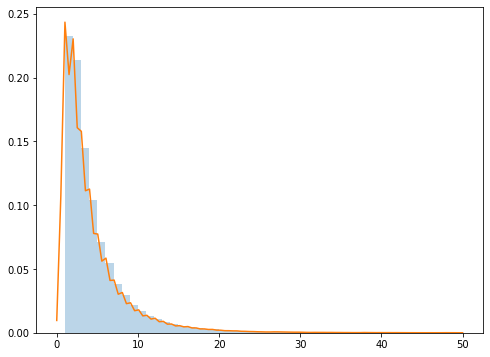

In [11]:
bins = np.arange(50)
count_prods = dfg['article_id'].count()

kde = stats.gaussian_kde(count_prods)
xx = np.linspace(0, 50, 100)
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(count_prods, density=True, bins=bins, alpha=0.3)
ax.plot(xx, kde(xx))

In [22]:
filtered_customers = list(cust_dict.keys())

all_seqs = [transactions[cust]['products'][0] for cust in filtered_customers]
seq_prods = set([item for sublist in all_seqs for item in sublist])
print(f"{len(seq_prods)} items in filtered sequences")

# items solely based on the considered interactions - tighter bounds
filtered_items = set([k for k in prod_dict if k in seq_prods])
print(f"Original {len(prod_dict)} items, remaining {len(filtered_items)} items")

# get the item counts so that most frequent item gets lowest id
item_counts = [(k, prod_dict[k]) for k in prod_dict if k in filtered_items]
item_counts = sorted(item_counts, key=lambda x: x[1], reverse=True)
print(item_counts[:5])

# create the item-dict, starting from 1
item_dict = {k[0]: ii+1 for ii, k in enumerate(item_counts)}
item_ids = list(item_dict.values())
print(f"Item-ids range from {min(item_ids)}, ... {max(item_ids)}")

35084 items in filtered sequences
Original 35084 items, remaining 35084 items
[('0751471001', 4110), ('0918292001', 3639), ('0706016001', 3563), ('0448509014', 2976), ('0751471043', 2939)]
Item-ids range from 1, ... 35084


In [23]:
write_train_file(data_dir=data_dir, 
                 file_name="hnm_7w.txt",
                 customer_list=filtered_customers, 
                 transactions=transactions, 
                 item_dict=item_dict, 
                 prod_dict=df_prod,
                 original_product_name=True,
                 write_product_meta=True)

100%|██████████| 367793/367793 [10:15<00:00, 597.77it/s]

Written 2074165 lines in /recsys_data/RecSys/h_and_m_personalized_fashion_recommendation/hnm_7w.txt, 367793 users and 35084 items
Sequence length, min: 1, averag: 5.639490147990854 and max: 243


In [24]:
df_ss = pd.read_csv(os.path.join(data_dir, "sample_submission.csv"))
ss_custs = set(df_ss['customer_id'].unique())
extra_custs = ss_custs - set(filtered_customers)
len(extra_custs)

1004187

In [13]:
dummy_pred = '0924243001 0924243002 0923758001 0918522001 0909370001 0866731001 0751471001 0915529003 0915529005 0448509014 0762846027 0714790020'

In [25]:
res_dir = "/recsys_data/RecSys/TransformerRec"
res_path = "hnm_7w_transformer/result.pkl"
sub_file = "submission_6.txt"

res_df = create_submission_file(res_dir, res_path, sub_file, item_dict, filtered_customers, extra_custs, dummy_pred)
res_df

(367793, 12)


100%|██████████| 35084/35084 [02:27<00:00, 238.38it/s]


,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0762846029 0783346001 0921226001 0783346001 08...
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0905518002 0918292001 0918292004 0918292001 07...
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0912204001 0918292004 0918292004 0918292004 09...
3,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,0706016003 0706016003 0706016003 0706016003 07...
4,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,0714032003 0570003081 0714032003 0843614015 08...
...,...,...
1371975,b4d51d8e2e1d2bebdccd24699306b0f796f5ea19e454a1...,0924243001 0924243002 0923758001 0918522001 09...
1371976,e0bc7e9cb17cf36f0e5687128f2fc9176822c8aa32fa25...,0924243001 0924243002 0923758001 0918522001 09...
1371977,9b3fbff7ea2350034d01aadf0602d6e570fbd7ad37dd52...,0924243001 0924243002 0923758001 0918522001 09...
1371978,06a1daaf2bd70a20d696f09211c818994bc47d274e7624...,0924243001 0924243002 0923758001 0918522001 09...


In [26]:
! kaggle competitions submit -c h-and-m-personalized-fashion-recommendations -f /recsys_data/RecSys/TransformerRec/submission_6.txt -m "attempt-12"

100%|████████████████████████████████████████| 258M/258M [00:05<00:00, 51.3MB/s]
Successfully submitted to H&M Personalized Fashion Recommendations

In [9]:
df_cust = pd.read_csv(os.path.join(data_dir, "customers.csv"))
df_cust

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...
...,...,...,...,...,...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,NaN,NaN,ACTIVE,NONE,24.0,7aa399f7e669990daba2d92c577b52237380662f36480b...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,NaN,NaN,ACTIVE,NONE,21.0,3f47f1279beb72215f4de557d950e0bfa73789d24acb5e...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,1.0,1.0,ACTIVE,Regularly,21.0,4563fc79215672cd6a863f2b4bf56b8f898f2d96ed590e...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,1.0,1.0,ACTIVE,Regularly,18.0,8892c18e9bc3dca6aa4000cb8094fc4b51ee8db2ed14d7...


## Collect Transaction Data per User

In [10]:
dfg = df_tr.groupby("customer_id")
cust_dict, prod_dict, transactions = {}, {}, {}
count_cust, count_prod = 0, 0
num_products = []
for ckey, df_c in tqdm(dfg):
    count_cust += 1
    cust_dict[ckey] = count_cust
    df_c = df_c.sort_values(by=['t_dat'])
    products = df_c['article_id'].tolist()
    dates = df_c['t_dat'].tolist()
    transactions[ckey] = {'products': [], 'days': []}
    for p in products:
        if p in prod_dict:
            prod_dict[p] += 1
        else:
            prod_dict[p] = 1
    transactions[ckey]['products'].append(products)
    transactions[ckey]['days'].append(dates)
    num_products.append(len(df_c['article_id'].unique()))

print(f"Total {len(cust_dict)} customers with average {np.mean(num_products):.0f} products")
print(f"Total {len(prod_dict)} items")

100%|██████████| 1362281/1362281 [20:17<00:00, 1118.70it/s]


Total 1362281 customers with average 20 products
Total 104547 items


In [12]:
count_prods = dfg['article_id'].count()
count_prods[count_prods<=13]

customer_id
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e     2
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a    13
000064249685c11552da43ef22a5030f35a147f723d5b02ddd9fd22452b1f5a6     3
0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d8cd0c725276a467a2a     6
00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77334eaec4ffccd7ebcc     2
                                                                    ..
ffff8f9ecdce722b5bab97fff68a6d1866492209bfe5242c50d2a10a652fb5ef     9
ffffa28cd7ab5d1cbbbfe7b582b1c419270cc0539f3dae5bdfa4cf4b5874c806     3
ffffaff3905b803d1c7e153a1378a5151e1f34f236ba5451afc7cf3f699c5690     1
ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38b2236865d949d4df6a     7
ffffd9ac14e89946416d80e791d064701994755c3ab686a1eaf3458c36f52241     1
Name: article_id, Length: 803935, dtype: int64

In [13]:
count_df = pd.DataFrame(count_prods)
count_df

,article_id
customer_id,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,21
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,86
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,18
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,2
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,13
...,...
ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e4747568cac33e8c541831,51
ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab53481233731b5c4f8b7,84
ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1778d0116cffd259264,45


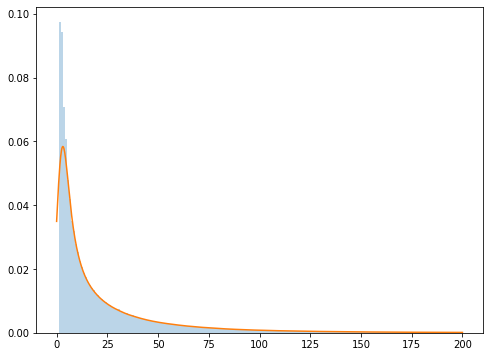

In [34]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# N = 100
# x = np.random.randint(0, 9, N)
bins = np.arange(200)

kde = stats.gaussian_kde(count_prods)
xx = np.linspace(0, 200, 1000)
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(count_prods, density=True, bins=bins, alpha=0.3)
ax.plot(xx, kde(xx))

1 1895


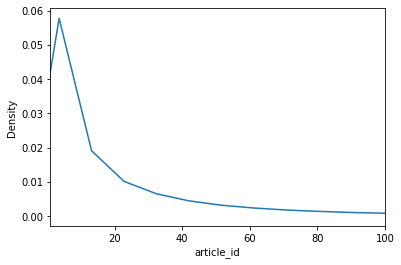

In [36]:
import seaborn as sns

fig, ax1 = plt.subplots()
sns.kdeplot(data=count_df, x="article_id", ax=ax1)
ax1.set_xlim((count_df["article_id"].min(), 100))
print(count_df["article_id"].min(), count_df["article_id"].max())

## Write the original data 

In [14]:
item_counts = [(k, prod_dict[k]) for k in prod_dict]
item_counts = sorted(item_counts, key=lambda x: x[1], reverse=True)
item_dict = {k[0]: ii+1 for ii, k in enumerate(item_counts)}

In [15]:
pattern = '%Y-%m-%d %H:%M:%S'
colsep = "\t"

count = 0
user_id = 0
seq_lens = []
out_file = os.path.join(data_dir, "hnm_big.txt")
with open(out_file, 'w') as fw:
    for cust in tqdm(transactions.keys()):
        items = transactions[cust]['products'][0]
        user_id += 1
        dates = transactions[cust]['days'][0]
        prods = [item_dict[ii] for ii in items]
        epochs = [int(time.mktime(time.strptime(str(date_time), pattern))) for date_time in dates]
        epochs = [e-epochs[0] for e in epochs]
        seq_lens.append(len(prods))
        for p, t in zip(prods, epochs):
            fw.write(colsep.join([str(user_id), str(p), str(t)])+'\n')
            count += 1
print(f"Written {count} lines in {out_file}, {user_id} users and {len(item_dict)} items")
print(f"Sequence length, min: {np.min(seq_lens)}, averag: {np.mean(seq_lens)} and max: {np.max(seq_lens)}")

100%|██████████| 1362281/1362281 [11:18<00:00, 2008.79it/s]


Written 31788324 lines in /recsys_data/RecSys/h_and_m_personalized_fashion_recommendation/hnm_big.txt, 1362281 users and 104547 items
Sequence length, min: 1, averag: 23.334630667241193 and max: 1895


### Remove items with few transactions

In [14]:
min_item_count = 2
min_seq_len = 1

filtered_customers = list(count_prods[count_prods>=min_seq_len].index)
print(f"Original {len(count_prods)} customers, remaining {len(filtered_customers)} customers")

all_seqs = [transactions[cust]['products'][0] for cust in filtered_customers]
seq_prods = set([item for sublist in all_seqs for item in sublist])
print(f"{len(seq_prods)} items in filtered sequences")

# items from the interactions and items based on overall number of interactions
# filtered_items = set([k for k in prod_dict if prod_dict[k] >= min_item_count or k in seq_prods])

# items solely based on the considered interactions - tighter bounds
filtered_items = set([k for k in prod_dict if k in seq_prods])
print(f"Original {len(prod_dict)} items, remaining {len(filtered_items)} items")

# get the item counts so that most frequent item gets lowest id
item_counts = [(k, prod_dict[k]) for k in prod_dict if k in filtered_items]
item_counts = sorted(item_counts, key=lambda x: x[1], reverse=True)
print(item_counts[:5])

# create the item-dict, starting from 1
item_dict = {k[0]: ii+1 for ii, k in enumerate(item_counts)}
item_ids = list(item_dict.values())
print(f"Item-ids range from {min(item_ids)}, ... {max(item_ids)}")

Original 1362281 customers, remaining 1362281 customers
104547 items in filtered sequences
Original 104547 items, remaining 104547 items
[(706016001, 50287), (706016002, 35043), (372860001, 31718), (610776002, 30199), (759871002, 26329)]
Item-ids range from 1, ... 104547


In [51]:
pattern = '%Y-%m-%d %H:%M:%S'
colsep = "\t"
write_product_meta = True
count = 0
user_id = 0
seq_lens = []
if write_product_meta:
    out_file = os.path.join(data_dir, "hnm_big_train_addl2.txt")
else:
    out_file = os.path.join(data_dir, "hnm_big_train.txt")

"""
{'product_code': 663713,
 'prod_name': 'Atlanta Push Body Harlow',
 'product_type_no': 283,
 'product_type_name': 'Underwear body',
 'product_group_name': 'Underwear',
 'graphical_appearance_no': 1010016,
 'graphical_appearance_name': 'Solid',
 'colour_group_code': 9,
 'colour_group_name': 'Black',
 'perceived_colour_value_id': 4,
 'perceived_colour_value_name': 'Dark',
 'perceived_colour_master_id': 5,
 'perceived_colour_master_name': 'Black',
 'department_no': 1338,
 'department_name': 'Expressive Lingerie',
 'index_code': 'B',
 'index_name': 'Lingeries/Tights',
 'index_group_no': 1,
 'index_group_name': 'Ladieswear',
 'section_no': 61,
 'section_name': 'Womens Lingerie',
 'garment_group_no': 1017,
 'garment_group_name': 'Under-, Nightwear',
 'detail_desc': 'Lace push-up body with underwired, moulded, padded cups for a larger bust and fuller cleavage. Narrow, adjustable shoulder straps, an opening with a hook-and-eye fastening at the back and a lined gusset with concealed press-studs.'}

"""    

include_meta = ['product_type_name', 'product_group_name', 'graphical_appearance_name', 
                'colour_group_name', 'department_name', 'index_name', 
                'index_group_name', 'section_name', 'garment_group_name'
               ]

with open(out_file, 'w') as fw:
    for cust in tqdm(filtered_customers):
        items = transactions[cust]['products'][0]
        user_id += 1
        dates = transactions[cust]['days'][0]
        prods = [item_dict[ii] for ii in items]
        
        epochs = [int(time.mktime(time.strptime(str(date_time), pattern))) for date_time in dates] # in seconds
        epochs = [int((e-epochs[0])/86400.) for e in epochs]
        seq_lens.append(len(prods))

        if write_product_meta:
            meta_info = {}
            meta_info['user_id'] = user_id
            meta_info['article_id'] = prods
            for jj in include_meta:
                data_ij = [df_prod[ii][jj] for ii in items]
                meta_info[jj] = data_ij
                
            meta_info['epochs'] = epochs
            meta_info = pd.DataFrame(meta_info)
            meta_info.to_csv(fw, sep=colsep, header=False, index=False)
            count += len(meta_info)
                
#             for index, row in meta_info.iterrows():
#                 out = [str(ii) for ii in row]
#                 out = colsep.join(out)
#                 fw.write(out + "\n")
#                 count += 1
                
            # other associated data, df_prod has all the product information
#             pt_names = [df_prod[ii]['product_type_name'] for ii in items]
#             dp_names = [df_prod[ii]['department_name'] for ii in items]
#             ig_names = [df_prod[ii]['index_group_name'] for ii in items]
#             gg_names = [df_prod[ii]['garment_group_name'] for ii in items]
        
            # product-id, metadata and time
#             for p, pt, dp, ig, gg, t in zip(prods, pt_names, dp_names, ig_names, gg_names, epochs):
#                 fw.write(colsep.join([str(user_id), str(p), str(pt), str(dp), str(ig), str(gg), str(t)])+'\n')
#                 count += 1

        else:
            # only product-id and time
            for p, t in zip(prods, epochs):
                fw.write(colsep.join([str(user_id), str(p), str(t)])+'\n')
                count += 1

print(f"Written {count} lines in {out_file}, {user_id} users and {len(item_dict)} items")
print(f"Sequence length, min: {np.min(seq_lens)}, averag: {np.mean(seq_lens)} and max: {np.max(seq_lens)}")

100%|██████████| 1362281/1362281 [48:29<00:00, 468.21it/s]


Written 31788324 lines in /recsys_data/RecSys/h_and_m_personalized_fashion_recommendation/hnm_big_train_addl2.txt, 1362281 users and 104547 items
Sequence length, min: 1, averag: 23.334630667241193 and max: 1895


In [48]:
out

'1\t29950\tJacket\tGarment Upper body\tSolid\tDark Blue\tYoung Boy Outdoor\tChildren Sizes 134-170\tBaby/Children\tKids Outerwear\tOutdoor\t0'

In [75]:
# exmpl = [df_prod[ii]['garment_group_name'] for ii in items]
# ['_'.join(ex.split()) for ex in exmpl]

In [112]:
# from argparse import Namespace
from types import SimpleNamespace
from collections import defaultdict
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [138]:
def create_dataset(data_dir, args):
    """
    Creates train-validation-test data sets from interaction data.
    Random split between train-validation based on certain percentage.

    We want to predict the next few items (pre-decided) without
    using any negative sampling.
    """
    inp_file = os.path.join(data_dir, args.dataset + ".txt")
    sample = pd.read_csv(inp_file, sep=args.colsep, nrows=5)
    ncol = sample.shape[1]
    if ncol == 1:
        raise ValueError("Not enough data to unpack!!")

    num_prod_dim = ncol - 3  # other than u, i, t
    if num_prod_dim > 0:
        prod_dict = [{} for _ in range(num_prod_dim)]

    def get_ids(elems):
        ids = []
        for ii, e in enumerate(elems):
            if e not in prod_dict[ii]:
                prod_dict[ii][e] = len(prod_dict[ii]) + 1
            ids.append(prod_dict[ii][e])
        return ids
    

    usernum = 0
    itemnum = 0
    User = defaultdict(list)
    test_X = []
    count = 0
    with open(inp_file, "r") as fr:
        for line in tqdm(fr):
            if ncol == 2:
                u, i = line.rstrip().split(args.colsep)
            elif ncol == 3:
                u, i, _ = line.rstrip().split(args.colsep)
            elif ncol >= 4:
                elems = line.rstrip().split(args.colsep)
                u, i, t = elems[0], elems[1], elems[-1]
                pdims = elems[2:-1]
                pids = get_ids(pdims)
            else:
                raise ValueError("Unknown number of columns")
            u = int(u)
            i = int(i)
            usernum = max(u, usernum)
            itemnum = max(i, itemnum)
            if ncol >= 4:
                User[u].append([i]+pids)
            else:
                User[u].append(i)
            count += 1
            if count > 1000:
                break

    print(len(User))
    all_X, all_y = [], []
    for user in User:
        nfeedback = len(User[user])
        test_X.append(User[user])  # entire sequence, all users
        if nfeedback < args.tgt_seq_len:
            continue
        else:
            all_X.append(User[user][: -args.tgt_seq_len])
            all_y.append(User[user][-args.tgt_seq_len :])

    all_X = tf.keras.preprocessing.sequence.pad_sequences(
        all_X, padding="pre", truncating="pre", maxlen=args.maxlen
    )
    
    all_y = np.array(all_y)
    all_y = all_y[:, :, 0]
    print(all_y.shape)
    
    test_X = tf.keras.preprocessing.sequence.pad_sequences(
        test_X, padding="pre", truncating="pre", maxlen=args.maxlen
    )

    X_train, X_valid, y_train, y_valid = train_test_split(
        all_X, all_y, test_size=0.20, random_state=42
    )

    y_train = np.array(y_train)
    y_valid = np.array(y_valid)

    return X_train, y_train, X_valid, y_valid, test_X, usernum, itemnum, prod_dict


In [139]:
args = SimpleNamespace(colsep="\t", 
                       dataset='hnm_big_train_addl',
                       maxlen=12,
                       tgt_seq_len=12
                      )

X_train, y_train, X_valid, y_valid, test_X, usernum, itemnum, meta_dict = create_dataset(data_dir, args)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, test_X.shape)

1000it [00:00, 251743.83it/s]

20
(20, 12)
(16, 12, 5) (16, 12) (4, 12, 5) (4, 12) (20, 12, 5)


In [22]:
len(item_dict), item_counts[-1]

(44671, (588423001, 100))

### Create Smaller Samples

In [26]:
import random

In [68]:
random.seed(100)
pattern = '%Y-%m-%d %H:%M:%S'
colsep = "\t"
min_seq_len = 10

num_users = 10000
item_set = set()
all_users = list(transactions.keys())
sample_users = random.choices(all_users, k=num_users)

count = 0
user_id = 0
item_id = 0
sample_user_dict, sample_item_dict = {}, {}
seq_lens = []
out_file = os.path.join(data_dir, "hnm_sample.txt")
with open(out_file, 'w') as fw:
    for cust in sample_users:
        items = transactions[cust]['products'][0]
        if len(items) > min_seq_len:
            user_id += 1
            dates = transactions[cust]['days'][0]
            for item in items:
                if item not in sample_item_dict:
                    item_id += 1
                    sample_item_dict[item] = item_id
            prods = [sample_item_dict[ii] for ii in items]
            epochs = [int(time.mktime(time.strptime(str(date_time), pattern))) for date_time in dates]
            seq_lens.append(len(prods))
            for p, t in zip(prods, epochs):
                fw.write(colsep.join([str(user_id), str(p), str(t)])+'\n')
                count += 1
print(f"Written {count} lines in {out_file}, {user_id} users and {item_id} items")
print(f"Sequence length, min: {np.min(seq_lens)}, averag: {np.mean(seq_lens)} and max: {np.max(seq_lens)}")

Written 208856 lines in /recsys_data/RecSys/h_and_m_personalized_fashion_recommendation/hnm_sample.txt, 4644 users and 44163 items
Sequence length, min: 11, averag: 44.97329888027562 and max: 658


### Write in SASRec Format

In [24]:
out_file = os.path.join(data_dir, "hnm_small.txt")
pattern = '%Y-%m-%d %H:%M:%S'
colsep = "\t"
count = 0
min_seq_len = 10
with open(out_file, 'w') as fw:
    for cust in tqdm(transactions.keys()):
        cid = cust_dict[cust]
        # keep only the items that are present in the dictionary
#         prods = [item_dict[p] for p in transactions[cust]['products'][0] if p in filtered_items]
        
        # add additional OOV token for products not present in the dictionary
        prods = [item_dict[p] if p in filtered_items else len(item_dict)+1 for p in transactions[cust]['products'][0]]
        dates = transactions[cust]['days'][0]
        epochs = [int(time.mktime(time.strptime(str(date_time), pattern))) for date_time in dates]
        if len(prods) > min_seq_len:
            for p, t in zip(prods, epochs):
                fw.write(colsep.join([str(cid), str(p), str(t)])+'\n')
                count += 1
print(f"Written {count} lines in {out_file}")

100%|██████████| 1362281/1362281 [11:32<00:00, 1967.32it/s]

Written 28765113 lines in /recsys_data/RecSys/h_and_m_personalized_fashion_recommendation/hnm_small.txt


In [37]:
! wc -l /recsys_data/RecSys/h_and_m_personalized_fashion_recommendation/hnm*.txt

  31788324 /recsys_data/RecSys/h_and_m_personalized_fashion_recommendation/hnm.txt
     22278 /recsys_data/RecSys/h_and_m_personalized_fashion_recommendation/hnm_sample.txt
  28765113 /recsys_data/RecSys/h_and_m_personalized_fashion_recommendation/hnm_small.txt
  60575715 total


### Sample Submission

In [16]:
df_ss = pd.read_csv(os.path.join(data_dir, "sample_submission.csv"))
df_ss

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0706016001 0706016002 0372860001 0610776002 07...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0706016001 0706016002 0372860001 0610776002 07...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0706016001 0706016002 0372860001 0610776002 07...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0706016001 0706016002 0372860001 0610776002 07...


In [52]:
len(df_ss['customer_id'].unique()), len(df_tr['customer_id'].unique())

(1371980, 1362281)

In [19]:
ss_custs = set(df_ss['customer_id'].unique())
extra_custs = ss_custs - set(df_tr['customer_id'].unique())
len(extra_custs)

9699

### Read Results and Prepare Submission File

In [33]:
import pickle

res_dir = "/recsys_data/RecSys/TransformerRec"
res_path = "hnm_big_train_addl_train/result.pkl"
# res_path = "hnm_big_train_train/result.pkl"

with open(os.path.join(res_dir, res_path), 'rb') as fr:
    pred = pickle.load(fr)
    
print(pred.shape)

(1362281, 12)


In [34]:
pred[:5]

array([[  165, 11385, 11385,  6068,  6068,  6068,  6068,  6068,  6068,
         6068,  6068, 64844],
       [  100,   100,   100,   100,   100,   100,   100,   100,   878,
          878,   100,    83],
       [21222, 21222,  8182,  8182,  8182,  9707,  9707,    21,    21,
           21,  5603,  1241],
       [   11,    11,    11,    11,    11,    11,    11,    11,    11,
           11,    11,    11],
       [ 2050,  2050,  2050,  2050,  2050,  7123,  7123,  7123,  7123,
         7123,  7123,    21]])

In [22]:
inv_item_dict = {v: k for k, v in item_dict.items()}  # for smaller set of products
# inv_prod_dict = {v: k for k, v in prod_dict.items()}  # for all the products

In [23]:
len(item_dict), len(inv_item_dict)

(104547, 104547)

In [24]:
most_frequent_item = 706016001

In [91]:
global_item_counts = [(k, prod_dict[k]) for k in prod_dict]
global_item_counts = sorted(global_item_counts, key=lambda x: x[1], reverse=True)
most_frequent_item = global_item_counts[0][0]
most_frequent_item

706016001

In [143]:
len(filtered_customers), filtered_customers[0], filtered_customers[-1]

(1362281,
 '00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657',
 'ffffd9ac14e89946416d80e791d064701994755c3ab686a1eaf3458c36f52241')

In [147]:
inv_item_dict[1]

706016001

In [35]:
# first map the prediction to product-ids - takes half an hour
from numpy import copy

pred2 = copy(pred)
for k in tqdm(inv_item_dict): 
    pred2[pred==k] = inv_item_dict[k]

100%|██████████| 104547/104547 [31:06<00:00, 56.01it/s]


In [26]:
pred2[:5]

array([[762846008, 751471001, 751471001, 751471001, 751471001, 751471001,
        751471001, 751471001, 751471001, 751471001, 751471001, 751471001],
       [599580055, 599580055, 599580055, 599580055, 599580055, 599580055,
        599580055, 599580055, 599580055, 599580055, 599580055, 599580038],
       [781758057, 781758057, 781758057, 751471043, 751471043, 889661001,
        889661001, 751471043, 751471043, 751471043, 751471043, 751471043],
       [708021001, 720125001, 720125001, 720125001, 720125001, 720125001,
        720125001, 720125001, 720125001, 720125001, 720125001, 720125001],
       [912204001, 912204001, 912204001, 912204001, 912204001, 912204001,
        912204001, 912204001, 730683050, 912204001, 912204001, 915529003]])

In [27]:
def id2string(row):
    return ' '.join(['0'+str(ii) for ii in row])


In [36]:
pred_extra = np.ones((len(extra_custs), 12), dtype=int) * most_frequent_item
pred3 = np.apply_along_axis(id2string, 1, pred2)
pred_extra2 = np.apply_along_axis(id2string, 1, pred_extra)

pred_all = np.concatenate((pred3, pred_extra2), axis=0)
pred3.shape, pred_extra2.shape, pred_all.shape

((1362281,), (9699,), (1371980,))

In [37]:
all_custs = filtered_customers + list(extra_custs)
len(all_custs)

1371980

In [38]:
res_df = pd.DataFrame({"customer_id": all_custs, "prediction": pred_all})
res_df.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0762846006 0857778011 0857778011 0867969003 08...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0599580055 0599580055 0599580055 0599580055 05...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0710876035 0710876035 0889456001 0889456001 08...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0720125001 0720125001 0720125001 0720125001 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0912204001 0912204001 0912204001 0912204001 09...


In [39]:
res_df.to_csv(os.path.join(res_dir, "submission_4.txt"), header=True, index=False)

### Upload to Kaggle

In [40]:
! kaggle competitions submit -c h-and-m-personalized-fashion-recommendations -f /recsys_data/RecSys/TransformerRec/submission_4.txt -m "attempt-4"

100%|████████████████████████████████████████| 258M/258M [00:08<00:00, 32.5MB/s]
Successfully submitted to H&M Personalized Fashion Recommendations

#### Takes too long to write like this

In [ ]:
with open(os.path.join(res_dir, "submission_3.txt"), 'w') as fw:
    fw.write(','.join(['customer_id', 'prediction'])+'\n')
    count = -1
    for cust in tqdm(ss_custs):
        # customers in the training scope
        if cust in filtered_customers:
            count += 1
            iids = pred2[count]
#             iids = [inv_item_dict[ii] for ii in iids]

        # customers currently *not* in training data
        else:
            iids = [most_frequent_item]*12
            
        all_prods = ' '.join(['0'+str(ii) for ii in iids])
        
        fw.write(','.join([cust, all_prods])+'\n')


### Baseline: All predictions are the most frequent product

In [103]:
# baseline - all products are the most frequent product
with open(os.path.join(res_dir, "submission_2.txt"), 'w') as fw:
    fw.write(','.join(['customer_id', 'prediction'])+'\n')
    count = -1
    for cust in tqdm(ss_custs):
        iids = [most_frequent_item]*12    
        all_prods = ' '.join(['0'+str(ii) for ii in iids])
        fw.write(','.join([cust, all_prods])+'\n')


100%|██████████| 1371980/1371980 [00:06<00:00, 218109.28it/s]


In [9]:
4%2

0